## 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

個人ノート
- torch.nn の使い方： https://pytorch.org/tutorials/beginner/nn_tutorial.html

## 70. 単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．
今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．
以下の行列・ベクトルを作成し，ファイルに保存せよ．

- 学習データの特徴量行列: Xtrain∈ℝNt×d
- 学習データのラベルベクトル: Ytrain∈ℕNt
- 検証データの特徴量行列: Xvalid∈ℝNv×d
- 検証データのラベルベクトル: Yvalid∈ℕNv
- 評価データの特徴量行列: Xtest∈ℝNe×d
- 評価データのラベルベクトル: Ytest∈ℕNe

なお，Nt,Nv,Ne はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [2]:
# !pip install torch

In [3]:
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np
import torch
import re

word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
label = {"b":0, "t":1, "e":2, "m":3}
filenames = ["train", "test", "valid"]
d = 300

In [4]:
for fname in filenames:
    df = pd.read_csv("data_60/"+fname+".txt", sep="\t", header=0)
    X = torch.zeros([len(df), d], dtype=torch.float)
    y = torch.zeros([len(df), 1], dtype=torch.int8)
    for i, data in zip(range(len(df)), df.iterrows()):
        y[i,0] = label[data[1]["category"]]
        title_tokens = data[1]["title"].split()
        X[i,:] = torch.from_numpy(word_vectors.get_mean_vector(keys=title_tokens, ignore_missing=True))
        
    # save as files
    torch.save(X, "X_"+fname+".pt")
    torch.save(y.squeeze().long(), "y_"+fname+".pt")

### 71. 単層ニューラルネットワークによる予測

問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

$$\hat{y}_1=softmax(x_1W)$$

$$\hat{Y} =softmax(X_{[1:4]}W)$$

ただし，softmax
はソフトマックス関数，X[1:4]∈R4×d
は特徴ベクトル x1,x2,x3,x4
を縦に並べた行列である．

In [5]:
X_train = torch.load("X_train.pt")

# weights (separate for 72. gradient calculation)
W_1 = torch.rand(d, 4)
W_set = W_1.clone()
W_1.requires_grad=True
W_set.requires_grad=True

# softmax
sm = torch.nn.Softmax(dim=-1)
y_1 = sm(torch.matmul(X_train[0, :], W_1))
y_set = sm(torch.matmul(X_train[:4, :], W_set))

y_1, y_set

(tensor([0.2788, 0.2692, 0.2054, 0.2467], grad_fn=<SoftmaxBackward0>),
 tensor([[0.2788, 0.2692, 0.2054, 0.2467],
         [0.2521, 0.2628, 0.2138, 0.2714],
         [0.2598, 0.2485, 0.2463, 0.2454],
         [0.2368, 0.2621, 0.2275, 0.2736]], grad_fn=<SoftmaxBackward0>))

### 72. 損失と勾配の計算

学習データの事例 x1
と事例集合 x1,x2,x3,x4
に対して，クロスエントロピー損失と，行列W
に対する勾配を計算せよ．なお，ある事例xi
に対して損失は次式で計算される．

$l_i$ = −log[事例xiがyiに分類される確率]

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．



In [6]:
Y = torch.load("y_train.pt")

# cross-entropy loss
loss_y_1 = -torch.log(y_1[int(Y[0])])
loss_y_set = torch.mean(-torch.log(y_set[:, [int(y) for y in Y[:4]]]))
print(loss_y_1, loss_y_set)

# gradient
loss_y_1.backward()
print(W_1.grad)
loss_y_set.backward()
print(W_set.grad)

tensor(1.2774, grad_fn=<NegBackward0>) tensor(1.3962, grad_fn=<MeanBackward0>)
tensor([[ 0.0034, -0.0013, -0.0010, -0.0012],
        [ 0.0032, -0.0012, -0.0009, -0.0011],
        [ 0.0023, -0.0008, -0.0006, -0.0008],
        ...,
        [ 0.0008, -0.0003, -0.0002, -0.0003],
        [-0.0247,  0.0092,  0.0070,  0.0085],
        [ 0.0134, -0.0050, -0.0038, -0.0046]])
tensor([[-5.5565e-04,  2.3147e-04,  8.2420e-05,  2.4176e-04],
        [-7.0057e-03,  3.6938e-03, -5.3830e-04,  3.8503e-03],
        [ 7.3784e-03, -3.8622e-03,  5.0192e-04, -4.0181e-03],
        ...,
        [ 1.0529e-02, -5.4789e-03,  6.0080e-04, -5.6512e-03],
        [-1.0952e-02,  5.8720e-03, -6.6792e-04,  5.7482e-03],
        [ 1.4881e-02, -7.7351e-03,  5.7038e-04, -7.7161e-03]])


### 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [7]:
from torch import nn

dim_in = 300
C = 4 # no. of classes

model = nn.Sequential(
    nn.Linear(dim_in, C, bias=False),
    nn.Softmax(dim=-1)
    )
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

X_train = torch.load("X_train.pt")
y_train = torch.load("y_train.pt")

EPOCHS = 100
for epoch in range(EPOCHS):
    # prediction and loss calculation
    pred = model(X_train)
    loss = loss_fn(pred, y_train)

    # backpropagation and SGD
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 9:
        print(f"epoch={epoch}, loss={loss.item()}")

epoch=9, loss=1.3865008354187012
epoch=19, loss=1.3864275217056274
epoch=29, loss=1.3863543272018433
epoch=39, loss=1.38628089427948
epoch=49, loss=1.3862074613571167
epoch=59, loss=1.386134147644043
epoch=69, loss=1.3860607147216797
epoch=79, loss=1.3859872817993164
epoch=89, loss=1.3859138488769531
epoch=99, loss=1.3858402967453003


### 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [9]:
from sklearn.metrics import accuracy_score

X_valid = torch.load("X_valid.pt")
y_valid = torch.load("y_valid.pt")

def get_acc(X, Y, classifier):
    with torch.no_grad(): # not record this in grad calculation
        pred = classifier(X)
        return (pred.argmax(dim=1)==Y).sum() / Y.size()[0]

get_acc(X_train, y_train, model), get_acc(X_valid, y_valid, model)

(tensor(0.2178), tensor(0.2294))

### 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [23]:
import matplotlib.pyplot as plt

# redefine model/optimizer
model = nn.Sequential(
    nn.Linear(dim_in, C, bias=False),
    nn.Softmax(dim=-1)
    )
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

X_train = torch.load("X_train.pt")
y_train = torch.load("y_train.pt")

EPOCHS = 10000
loss_t = torch.zeros([2, EPOCHS], dtype=torch.float)
acc_t = torch.zeros([2, EPOCHS], dtype=torch.float)
for epoch in range(EPOCHS):
    # prediction and loss calculation
    pred = model(X_train)
    loss = loss_fn(pred, y_train)

    # backpropagation and SGD
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # added from 74.
    # collect loss, acc values
    with torch.no_grad():
        loss_t[0, epoch] = loss
        acc_t[0, epoch] = get_acc(X_train, y_train, model)
        loss_t[1, epoch] = loss_fn(model(X_valid), y_valid)
        acc_t[1, epoch] = get_acc(X_valid, y_valid, model)

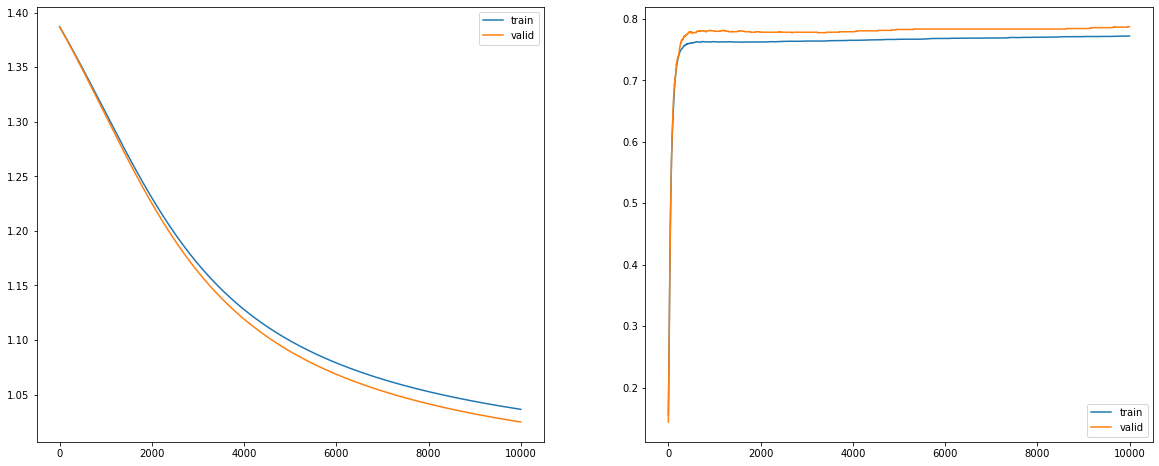

In [24]:
# plot epoch-loss, epoch-acc of train and valid 
fig = plt.figure(figsize=(20, 8))
ax_loss = fig.add_subplot(121)
ax_loss.plot(range(EPOCHS), loss_t[0,:].detach().numpy(), label="train")
ax_loss.plot(range(EPOCHS), loss_t[1,:].detach().numpy(), label="valid")
plt.legend()

ax_acc = fig.add_subplot(122)
ax_acc.plot(range(EPOCHS), acc_t[0,:].detach().numpy(), label="train")
ax_acc.plot(range(EPOCHS), acc_t[1,:].detach().numpy(), label="valid")
plt.legend()
plt.show()

### 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [20]:
# redefine model/optimizer
model = nn.Sequential(
    nn.Linear(dim_in, C, bias=False),
    nn.Softmax(dim=-1)
    )
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#loss_fn = nn.CrossEntropyLoss()

X_train = torch.load("X_train.pt")
y_train = torch.load("y_train.pt")

EPOCHS = 100
for epoch in range(EPOCHS):
    for x, y in zip(X_train, y_train):
        # prediction and loss calculation
        pred = model(x)
        loss = loss_fn(pred, y)

        # backpropagation and SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # changed from 75.
    # collect weights (model), optimizer state
    with torch.no_grad():
        torch.save({'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                   }, 'checkpoints/checkpoint-'+str(epoch)+'.pt')
        
# check result
cp = torch.load('checkpoints/checkpoint-50.pt')
cp

{'model': OrderedDict([('0.weight',
               tensor([[-1.3553,  0.0884, -0.9608,  ...,  1.9498,  1.6075, -1.9848],
                       [ 0.8788, -0.0880,  1.0990,  ..., -0.5389, -2.3047, -0.2771],
                       [ 1.5462,  0.2335, -1.6150,  ..., -2.0580, -0.5628,  0.8395],
                       [-1.1681, -0.2698,  1.3290,  ...,  0.6792,  1.2132,  1.5417]]))]),
 'optimizer': {'state': {0: {'momentum_buffer': None}},
  'param_groups': [{'lr': 0.1,
    'momentum': 0,
    'dampening': 0,
    'weight_decay': 0,
    'nesterov': False,
    'maximize': False,
    'params': [0]}]}}

### 77. ミニバッチ化
問題76のコードを改変し，B 事例ごと(Batch) に損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．B
の値を1,2,4,8,…
と変化させながら，1エポックの学習に要する時間を比較せよ．

Solution #1: 手動でデータを minibatch に分割する

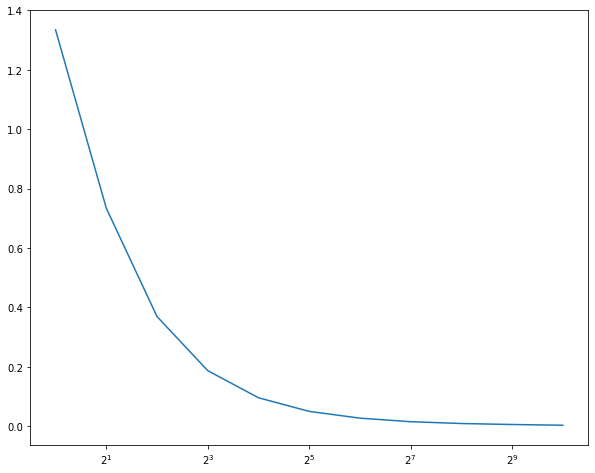

In [22]:
import time

# # redefine model/optimizer
# model = nn.Sequential(
#     nn.Linear(dim_in, C, bias=False),
#     nn.Softmax(dim=-1)
#     )
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# #loss_fn = nn.CrossEntropyLoss()

X_train = torch.load("X_train.pt")
y_train = torch.load("y_train.pt")

# minibatch: batch-size data/epoch
EPOCHS = 100
BATCHES = [2**i for i in range(11)] # batch size 1,2,4,...,1024
times_rec = []
n = len(X_train)

for B in BATCHES:
    times_tmp = []
    model = nn.Sequential(
        nn.Linear(dim_in, C, bias=False),
        nn.Softmax(dim=-1)
        )
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    for epoch in range(EPOCHS):
        start_epoch = time.time()
        for i in range((n-1)//B + 1):
            # set indices and time variables
            start_i = B * i
            end_i = start_i + B

            # prediction and loss calculation
            pred = model(X_train[start_i:end_i])
            loss = loss_fn(pred, y_train[start_i:end_i])

            # backpropagation and SGD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # execution time measurement
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        times_tmp.append(elapsed)
    
    # add avg execution time per epoch
    times_rec.append(sum(times_tmp)/EPOCHS)

# plot time
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_xscale('log', basex=2)
ax.plot(BATCHES, times_rec)
plt.show()

Solution #2: use TensorDataset, DataLoader

note: 少し速くなる

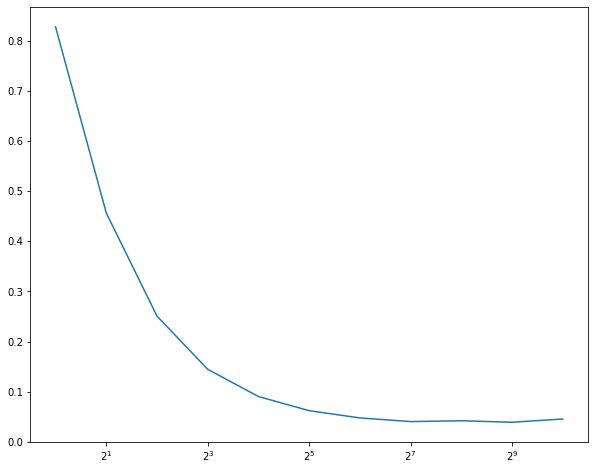

In [24]:
from torch.utils.data import TensorDataset, DataLoader
import time

# # redefine model/optimizer
# model = nn.Sequential(
#     nn.Linear(dim_in, C, bias=False),
#     nn.Softmax(dim=-1)
#     )
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# #loss_fn = nn.CrossEntropyLoss()

# minibatch: batch-size data/epoch
EPOCHS = 100
BATCHES = [2**i for i in range(11)] # batch size 1,2,4,...,1024
times_rec = []
train_ds = TensorDataset(X_train, y_train)

for B in BATCHES:
    times_tmp = []
    model = nn.Sequential(
        nn.Linear(dim_in, C, bias=False),
        nn.Softmax(dim=-1)
        )
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_dl = DataLoader(train_ds, batch_size=B)
    for epoch in range(EPOCHS):
        # set time variable
        start_epoch = time.time()
        
        # prediction and loss calculation
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
        
        # backpropagation and SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # execution time measurement
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        times_tmp.append(elapsed)
    
    # add avg execution time per epoch
    times_rec.append(sum(times_tmp)/EPOCHS)

# plot time
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_xscale('log', basex=2)
ax.plot(BATCHES, times_rec)
plt.show()

### 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [25]:
# check access to gpu
print(torch.cuda.is_available())

True


In [26]:
!nvidia-smi

Mon Jun 20 18:01:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 28%   37C    P8    30W / 250W |      3MiB / 11011MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   

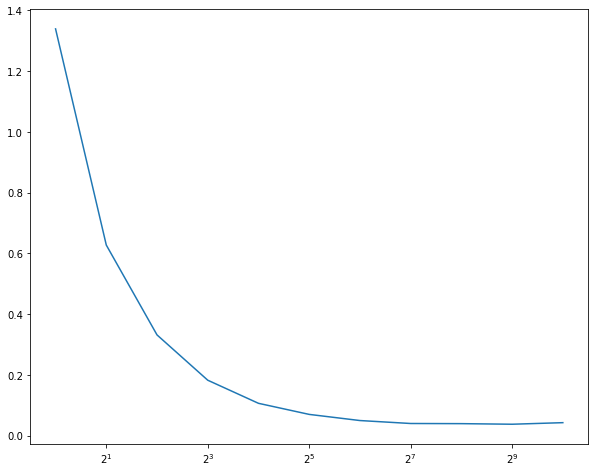

In [27]:
# CUDA device
cuda = torch.device("cuda")

# minibatch: batch-size data/epoch
EPOCHS = 100
BATCHES = [2**i for i in range(11)] # batch size 1,2,4,...,1024
times_rec = []

# move data to GPU
train_ds = TensorDataset(X_train.to(cuda), y_train.to(cuda))

for B in BATCHES:
    # initialization
    times_tmp = []
    model = nn.Sequential(
        nn.Linear(dim_in, C, bias=False),
        nn.Softmax(dim=-1)
        )
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 
    
    # move model to GPU
    model.to(cuda)
    
    train_dl = DataLoader(train_ds, batch_size=B)
    for epoch in range(EPOCHS):
        # set time variable
        start_epoch = time.time()
        
        # prediction and loss calculation
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
        
        # backpropagation and SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # execution time measurement
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        times_tmp.append(elapsed)
    
    # add avg execution time per epoch
    times_rec.append(sum(times_tmp)/EPOCHS)
    
# plot time
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_xscale('log', basex=2)
ax.plot(BATCHES, times_rec)
plt.show()

### 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [45]:
# 75. の train, valid の正解率
acc_t[:,-1]

tensor([0.6856, 0.7091])

In [59]:
# CUDA device
cuda = torch.device("cuda")

# minibatch: batch-size data/epoch
EPOCHS = 100
BATCHES = [2**i for i in range(11)] # batch size 1,2,4,...,1024

# for recording results
times_rec = []
acc_79 = torch.zeros([2, len(BATCHES), EPOCHS], dtype=torch.float)
acc_79.to(cuda)

# move data to GPU
train_ds = TensorDataset(X_train.to(cuda), y_train.to(cuda))

for B in BATCHES:
    # initialization
    times_tmp = []
    model = nn.Sequential(
        nn.Linear(dim_in, 64, bias=True),
        nn.LayerNorm(64),
        nn.Linear(64, C, bias=True),
        nn.Softmax(dim=-1)
        )
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 
    
    # move model to GPU
    model.to(cuda)
    
    train_dl = DataLoader(train_ds, batch_size=B)
    for epoch in range(EPOCHS):
        # set time variable
        start_epoch = time.time()
        
        # prediction and loss calculation
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
        
        # backpropagation and SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # execution time measurement
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        times_tmp.append(elapsed)

        with torch.no_grad():
            acc_79[0, int(np.log2(B)), epoch] = get_acc(X_train.to(cuda), y_train.to(cuda), model)
            acc_79[1, int(np.log2(B)), epoch] = get_acc(X_valid.to(cuda), y_valid.to(cuda), model)
    
    # add avg execution time per epoch
    times_rec.append(sum(times_tmp)/EPOCHS)

acc_79.argmax(), acc_79.max()

(tensor(2162), tensor(0.7871))

In [60]:
# best mini-batch size and the accuracies in training and valid
torch.argmax(acc_79[0,:,-1]), torch.max(acc_79[0,:,-1]), torch.max(acc_79[1,:,-1])

(tensor(8), tensor(0.7665), tensor(0.7826))

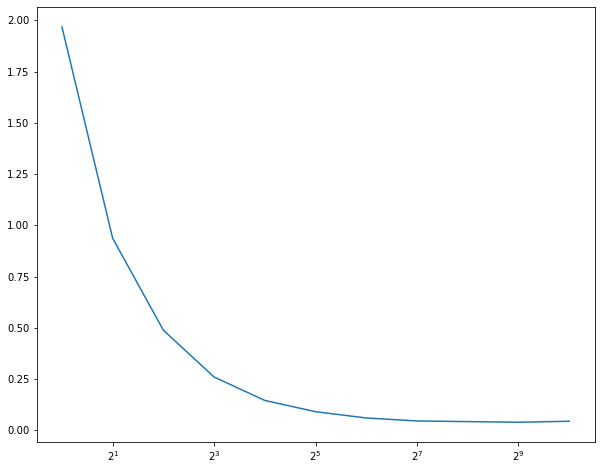

In [61]:
# plot time
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_xscale('log', basex=2)
ax.plot(BATCHES, times_rec)
plt.show()